In [31]:
import cv2
import numpy as np
import hashlib
import matplotlib.pyplot as plt

def embed_watermark(original_img, signature, strength=0.1):
    # Convert to YCbCr and extract Y channel
    img_ycbcr = cv2.cvtColor(original_img, cv2.COLOR_BGR2YCrCb)
    y_channel = img_ycbcr[:, :, 0].astype(np.float32)

    # Generate watermark sequence using hash of signature
    seed = int(hashlib.sha256(signature.encode()).hexdigest(), 16) % (2**32)
    np.random.seed(seed)
    watermark = np.random.randn(*y_channel.shape)  # Gaussian sequence

    # Split into 8x8 blocks and apply DCT
    watermarked = y_channel.copy()
    h, w = y_channel.shape
    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = y_channel[i:i+8, j:j+8]
            dct_block = cv2.dct(block)
            
            # Select mid-frequency coefficients (example: indices 5-20 in zigzag order)
            mask = np.zeros((8, 8), dtype=bool)
            mask.flat[5:20] = True  # Adjust based on JND thresholds
            
            # Embed watermark into selected coefficients
            dct_block[mask] += strength * watermark[i:i+8, j:j+8][mask]
            
            # Inverse DCT
            watermarked_block = cv2.idct(dct_block)
            watermarked[i:i+8, j:j+8] = watermarked_block

    # Reconstruct YCbCr and convert back to BGR
    img_ycbcr[:, :, 0] = np.clip(watermarked, 0, 255)
    watermarked_img = cv2.cvtColor(img_ycbcr, cv2.COLOR_YCrCb2BGR)
    return watermarked_img.astype(np.uint8)

In [32]:
def detect_watermark(test_img, signature, strength=0.1, threshold=3.0):
    # Convert to YCbCr and extract Y channel
    img_ycbcr = cv2.cvtColor(test_img, cv2.COLOR_BGR2YCrCb)
    y_channel = img_ycbcr[:, :, 0].astype(np.float32)

    # Regenerate the watermark sequence
    seed = int(hashlib.sha256(signature.encode()).hexdigest(), 16) % (2**32)
    np.random.seed(seed)
    watermark = np.random.randn(*y_channel.shape)

    # Compute correlation
    h, w = y_channel.shape
    correlations = []
    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = y_channel[i:i+8, j:j+8]
            dct_block = cv2.dct(block)
            
            # Use the same mask as embedding
            mask = np.zeros((8, 8), dtype=bool)
            mask.flat[5:20] = True
            
            # Extract coefficients and correlate with watermark
            selected_coeffs = dct_block[mask]
            selected_watermark = watermark[i:i+8, j:j+8][mask]
            if len(selected_coeffs) > 0:
                corr = np.dot(selected_coeffs.flatten(), selected_watermark.flatten())
                correlations.append(corr)

    # Calculate test statistic q
    n = len(correlations)
    if n == 0:
        return 0.0, False
    mean_corr = np.mean(correlations)
    std_corr = np.std(correlations)
    q = (mean_corr / std_corr) * np.sqrt(n)
    
    # Determine if watermark is present
    return q, q > threshold

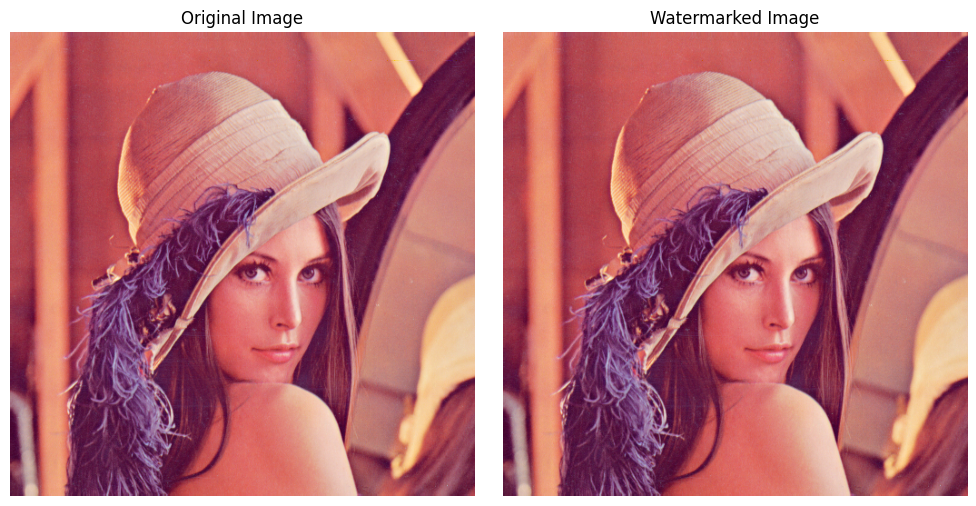


Detection Result:
Test Statistic q: 9.15
Watermark Detected: True


In [40]:
# Load original image
original_img = cv2.imread('lenna.png')
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Embed watermark
signature = "wuhfnehfnefij"
watermarked_img = embed_watermark(original_img, signature, strength=0.1)
watermarked_img_rgb = cv2.cvtColor(watermarked_img, cv2.COLOR_BGR2RGB)

# Display images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_img_rgb)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(watermarked_img_rgb)
plt.title('Watermarked Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Save and detect
cv2.imwrite('watermarked_lena.png', watermarked_img)
test_img = cv2.imread('watermarked_lena.png')

# Detect watermark
q, detected = detect_watermark(test_img, signature, threshold=3.0)
print(f"\nDetection Result:")
print(f"Test Statistic q: {q:.2f}")
print(f"Watermark Detected: {detected}")

In [34]:
def detect_multiple_watermarks(test_img, candidate_signatures, strength=0.1, threshold=3.0):
    img_ycbcr = cv2.cvtColor(test_img, cv2.COLOR_BGR2YCrCb)
    y_channel = img_ycbcr[:, :, 0].astype(np.float32)
    
    best_q = -np.inf
    best_index = -1
    
    for sig_idx, signature in enumerate(candidate_signatures):
        # Regenerate watermark for this signature
        seed = int(hashlib.sha256(signature.encode()).hexdigest(), 16) % (2**32)
        np.random.seed(seed)
        watermark = np.random.randn(*y_channel.shape)
        
        # Compute correlation
        correlations = []
        h, w = y_channel.shape
        for i in range(0, h, 8):
            for j in range(0, w, 8):
                block = y_channel[i:i+8, j:j+8]
                dct_block = cv2.dct(block)
                mask = np.zeros((8, 8), dtype=bool)
                mask.flat[5:20] = True
                selected_coeffs = dct_block[mask]
                selected_watermark = watermark[i:i+8, j:j+8][mask]
                if len(selected_coeffs) > 0:
                    corr = np.dot(selected_coeffs.flatten(), selected_watermark.flatten())
                    correlations.append(corr)
        
        # Calculate test statistic
        n = len(correlations)
        if n == 0:
            continue
        mean_corr = np.mean(correlations)
        std_corr = np.std(correlations)
        q = (mean_corr / std_corr) * np.sqrt(n)
        
        # Track best match
        if q > best_q:
            best_q = q
            best_index = sig_idx

    # Determine result
    detected = best_q > threshold
    return {
        'detected': detected,
        'best_match_index': best_index if detected else -1,
        'best_match_q': best_q,
        'all_q_values': [best_q if i == best_index else 0 for i in range(len(candidate_signatures))]
    }

In [41]:
# Candidate signatures (up to 3)
candidates = [
    "ChatGPT",  # Original signature
    "Stable Diffusion",
    "Midjourney"
]

# Detect watermarks
result = detect_multiple_watermarks(test_img, candidates, threshold=3.0)

print(f"Watermark Detected: {result['detected']}")
if result['detected']:
    print(f"Matched Signature Index: {result['best_match_index']}")
    print(f"Matched Signature Text: {candidates[result['best_match_index']]}")
    print(f"Confidence (q-value): {result['best_match_q']:.2f}")
    
print("\nAll Q-values:")
for idx, q in enumerate(result['all_q_values']):
    print(f"Signature {idx} ({candidates[idx]}): {q:.2f}")

Watermark Detected: False

All Q-values:
Signature 0 (ChatGPT): 0.00
Signature 1 (Stable Diffusion): 0.00
Signature 2 (Midjourney): 2.66
